# Изучение закономерностей, определяющих успешность продаж видеоигр

## 1 Описание проекта

**Задачи проекта:** используя исторические данные о продажах видеоигр, оценки пользователей и экспертов, жанры и платформы, выявить закономерности, определяющие успешность игр.

**Данные для анализа:** исторические данные из открытых источников о продажах игр, оценках пользователей и экспертов, жанрах и платформах за период 1980-2016 гг.

**Этапы проекта:**
- [предобработка данных](#preprocessing)
- [исследовательский анализ данных](#correlation)
- [анализ региональных особенностей продаж](#regions)
- [проверка гипотез](#hypotheses)
- [формирование общего вывода и рекомендаций](#conclusion)

<a id='preprocessing'></a>
## 2 Изучение и предобработка данных

In [1]:
# импортируем необходимые библиотеки и делаем настройки отображения
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from pandas.api.types import CategoricalDtype

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('games.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Приведем названия столбцов к нижнему регистру.

In [3]:
df.columns = df.columns.str.lower()
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Чтобы исключить дубликаты, связанные с использованием разных регистров написания, приведем значения столбцов `name` `platform` `genre` `rating` к нижнему регистру, воспользовавшись методом `str.lower()`

In [4]:
str_lower_cols = ['name', 'platform', 'genre', 'rating']

for col in str_lower_cols:
    df[col] = df[col].str.lower()

В данных есть строки, в которых отсутствуют значения в столбце `name`, выведем эти строки.

In [5]:
df[df['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,gen,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,gen,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Всего 2 строки с пустым `name`, в которых много отсутствующих данных. Эти строки можно удалить.

In [6]:
df = df.dropna(subset=['name'])

В данных есть строки, в которых отсутствуют значения в столбце `year_of_release`, определим их долю.

In [7]:
print('Кол-во строк с пропусками в year_of_release:', df['year_of_release'].isnull().sum())
print('Доля строк с пропусками в year_of_release:', round(df['year_of_release'].isnull().sum() / len(df) * 100, ndigits=1))

Кол-во строк с пропусками в year_of_release: 269
Доля строк с пропусками в year_of_release: 1.6


Доля строк с пустым `year_of_release` очень мала, поэтому их также можно удалить. Одновременно переведем данные в целочисленный формат.

In [8]:
df = df.dropna(subset=['year_of_release'])
df['year_of_release'] = df['year_of_release'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   object 
 10  rating           9768 non-null   object 
dtypes: float64(5), int32(1), object(5)
memory usage: 1.4+ MB


Пропуски в `critic_score` и `user_score` заменим условным маркером `-1`, потому что это субъективные оценочные данные, которые невозможно рассчитать. После посмотрим на списки уникальных значений, которыми представлены эти столбцы.

In [9]:
df['critic_score'] = df['critic_score'].fillna(-1)
df['user_score'] = df['user_score'].fillna(-1)

In [10]:
df['critic_score'].unique()

array([76., -1., 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

In [11]:
df['user_score'].unique()

array(['8', -1, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В столбце `user_score` встречается значение `tbd` – to be determened, т.е. рейтинг не может быть определен из-за малого кол-ва данных. Выведем строки с таким значением.

In [12]:
df.query('user_score == "tbd"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,zumba fitness,wii,2010,sports,3.45,2.59,0.0,0.66,-1.0,tbd,e
301,namco museum: 50th anniversary,ps2,2005,misc,2.08,1.35,0.0,0.54,61.0,tbd,e10+
520,zumba fitness 2,wii,2011,sports,1.51,1.03,0.0,0.27,-1.0,tbd,t
645,udraw studio,wii,2010,misc,1.65,0.57,0.0,0.20,71.0,tbd,e
718,just dance kids,wii,2010,misc,1.52,0.54,0.0,0.18,-1.0,tbd,e
...,...,...,...,...,...,...,...,...,...,...,...
16695,planet monsters,gba,2001,action,0.01,0.00,0.0,0.00,67.0,tbd,e
16697,bust-a-move 3000,gc,2003,puzzle,0.01,0.00,0.0,0.00,53.0,tbd,e
16698,mega brain boost,ds,2008,puzzle,0.01,0.00,0.0,0.00,48.0,tbd,e
16704,plushees,ds,2008,simulation,0.01,0.00,0.0,0.00,-1.0,tbd,e


`tbd` невозможно заменить каким-либо расчетным значением, поэтому для заполнения будем также использовать условный маркер `-1` Одновременно данные в `user_score` переведем в числовой формат float.

In [13]:
df['user_score'] = np.where(df['user_score'] == 'tbd', -1, df['user_score']).astype('float')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  float64
 9   user_score       16444 non-null  float64
 10  rating           9768 non-null   object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.4+ MB


Выведем список уникальных значений столбца `rating`

In [15]:
df['rating'].unique()

array(['e', nan, 'm', 't', 'e10+', 'k-a', 'ao', 'ec', 'rp'], dtype=object)

Представленная в данных рейтинговая система компьютерных игр – это рейтинги ESRB, действующие на территории США и Канады.

В данных есть отсутствующие значения – NAN и обозначение `K-A` (Kids to Adults), которое в современной рейтинговой системе соответствует `E` (Everyone).

Отсутствие рейтинга не всегда означает, что он не определен из-за малого кол-ва оценок (т.е. теоретически мог бы быть заменен на Rating Pending (RP) — Рейтинг ожидается). Отсутствующий рейтинг может означать, что игра не имеет оценки по ESRB, поскольку выпущена за пределами США и Канады (например, имеет оценку по PEGI – Европа или CERO – Япония), или что исходный датасет содержит не всю актуальную информацию.   

Заменим отсутствующие значения на маркер `unk` (*unknown*), а `K-A` – на актуальный `E`.

In [16]:
df['rating'] = df['rating'].fillna('unk')
df['rating'] = np.where(df['rating'] == 'k-a', 'e', df['rating'])

Проверим данные на наличие полных дубликатов. Определим их как те, у которых совпадают значения в столбцах `name` `platform` `genre` `year_of_release`

In [17]:
df.loc[df.duplicated(subset=['name', 'platform','genre','year_of_release'], keep=False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,madden nfl 13,ps3,2012,sports,2.11,0.22,0.0,0.23,83.0,5.5,e
16230,madden nfl 13,ps3,2012,sports,0.00,0.01,0.0,0.00,83.0,5.5,e


Удалим дублирование, оставив первый вариант вхождения, как более полный по содержащейся в нем информации.

In [18]:
df = df.drop_duplicates(subset=['name', 'platform','genre','year_of_release'], keep='first').copy()

Добавим в таблицу новый столбец `total_sales`, просуммировав для него значения столбцов с `na_sales` по `other_sales`    

In [19]:
df['total_sales'] = df.loc[:, 'na_sales':'other_sales'].sum(axis=1)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,e,82.54
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,-1.0,-1.0,unk,40.24
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,e,35.52
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,e,32.77
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,-1.0,-1.0,unk,31.38


Посмотрим на список уникальных значений столбца `platform`

In [20]:
df['platform'].unique()

array(['wii', 'nes', 'gb', 'ds', 'x360', 'ps3', 'ps2', 'snes', 'gba',
       'ps4', '3ds', 'n64', 'ps', 'xb', 'pc', '2600', 'psp', 'xone',
       'wiiu', 'gc', 'gen', 'dc', 'psv', 'sat', 'scd', 'ws', 'ng', 'tg16',
       '3do', 'gg', 'pcfx'], dtype=object)

Обогатим данные информацией о компаниях-разработчиках игровых платформ.

In [21]:
pc = pd.DataFrame({'company': 'pc', 'platform': ['pc']})
sony = pd.DataFrame({'company': 'sony', 'platform': ['ps', 'ps2', 'ps3', 'ps4', 'psv', 'psp']})
ms = pd.DataFrame({'company': 'ms', 'platform': ['x360', 'xone', 'xb']})
nintendo = pd.DataFrame({'company': 'nintendo', 'platform': ['gb', 'ds', 'nes', 'snes', 'gba', '3ds', 'n64', 'wii', 'wiiu', 'gc']})
others = pd.DataFrame({'company': 'others', 'platform': ['2600', 'gen', 'dc', 'sat', 'scd', 'ws', 'ng', 'tg16', '3do', 'gg', 'pcfx']})
company = pd.concat([pc, sony, ms, nintendo, others])

In [22]:
df = pd.merge(df, company, how='left', on='platform')
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,company
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,e,82.54,nintendo
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,-1.0,-1.0,unk,40.24,nintendo
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,e,35.52,nintendo
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,e,32.77,nintendo
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,-1.0,-1.0,unk,31.38,nintendo


### 2.1 Вывод

На этапе предобработки данных были выполнены следующие преобразования:

- приведены к нижнему регистру названия столбцов;
- приведены к нижнему регистру значения столбцов `name` `platform` `genre` `rating`, чтобы исключить дубликаты, связанные с использованием разных регистров написания, приведем;
- удалены строки с пропусками в столбце `name` (2 шт), поскольку в них отсутствовали ключевые параметры – платформа и жанр;
- удалены строки с пропусками в `year_of_release` (269 шт – 1.6%), поскольку нет варианта замены пропусков достоверными данными;
- изменен тип данных в столбцах: `year_of_release` – на целочисленный int, `user_score` – на числовой float;
- использован условный маркер `-1` для замены пропусков и неопределенных значений (`tbd`) в столбцах `critic_score` и `user_score`;
- использовано условное обозначение `unk` для замены отсутствующих значений в столбце `rating`;
- актуализированы устаревшие обозначения рейтингов в столбце `rating`;
- удалены полные дубликаты строк.

После предобработки в датасет были добавлены столбцы: 

- `total_sale` с суммарными продажами по всем регионам,
- `company` с компанией-разработчиком игровой платформы.

<a id='correlation'></a>
## 3 Исследовательский анализ данных

### Общая динамика выпуска игра

Посмотрим на динамику выпуска видеоигр на глобальном рынке.

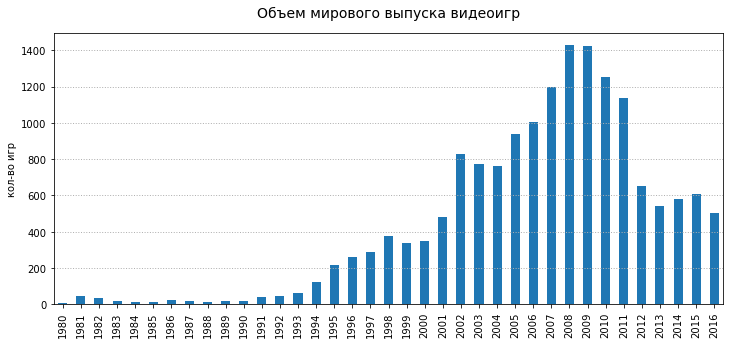

In [23]:
df.groupby('year_of_release').agg({'year_of_release': 'count'}).plot(kind='bar', figsize=(12, 5), linewidth=2, legend=False)

plt.title('Объем мирового выпуска видеоигр', fontsize=14, pad=15)
plt.xlabel('')
plt.ylabel('кол-во игр')
plt.grid(axis='y', linestyle=':', linewidth=1)
plt.show()

#### 3.1.1 Вывод

На графике видно следующее:
- С 1998 г. рынок видеоигр начал активно развиваться и расти, к 2008 г. достиг своего исторического максимума на отметке более 1400 игр в год.
- После 2009 г. рынок резко начинает падать и к 2013 г. снижается практически до уровня 2001 г., сократившись более, чем в 2.5 раза, скорее всего из-за появления мобильных игр (для смартфонов и планшетов).
- С 2013 г. рынок развивается без резких колебаний, но с тенденцией к снижению.  Хотя, возможно, падение 2016 г. связано с отсутствием полных данных за этот период.

Для целей прогнозирования будущих периодов (2017 г.) имеет смысл анализировать данные, начиная с 2013 г., поскольку этот период показывает характер развития рынка видеоигр при наличии его главного конкурента – рынка мобильных игр.

### 3.2 Динамика продаж по платформам

Посмотрите, как менялись продажи игр по платформам. Для этого выберем платформы с наибольшими суммарными продажами игр (топ-10).

In [24]:
platforms_top10 = (df.groupby(['platform', 'company'])
                     .agg({'total_sales': 'sum'})
                     .sort_values(by='total_sales', ascending=False)
                     .reset_index()
                     .head(10)
                  )
platforms_top10 #список 10 платформ с максимальными продажами игр

,platform,company,total_sales
0,ps2,sony,1233.56
1,x360,ms,961.24
2,ps3,sony,931.33
3,wii,nintendo,891.18
4,ds,nintendo,802.78
5,ps,sony,727.58
6,ps4,sony,314.14
7,gba,nintendo,312.88
8,psp,sony,289.53
9,3ds,nintendo,257.81


In [25]:
df_top10_grouped = (df[df['platform'].isin(platforms_top10['platform'].unique())]
                    .groupby(['platform', 'company', 'year_of_release'])
                    .agg({'total_sales': 'sum'})
                    .reset_index()
                   )

In [26]:
palettes=['Blues', 'Purples_r', 'Greens_r']

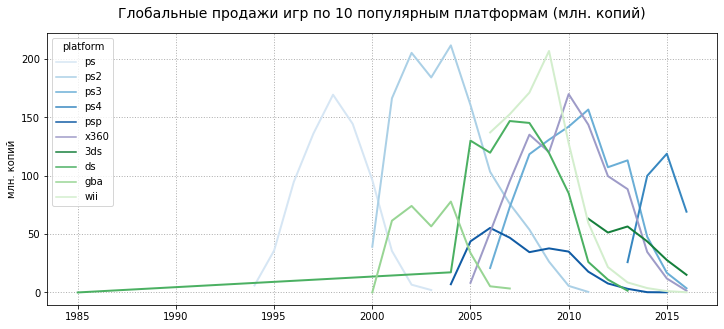

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (12, 5))

count = 0
for i in platforms_top10['company'].unique():

    sns.lineplot(x='year_of_release',
                 y='total_sales',
                 data=df_top10_grouped.query('company == @i'),
                 hue='platform',
                 legend='brief',
                 palette=palettes[count],
                 linewidth=2
                )
    count += 1
    
plt.title('Глобальные продажи игр по 10 популярным платформам (млн. копий)', fontsize=14, pad=15)
plt.xlabel('')
plt.ylabel('млн. копий')
plt.grid(linestyle=':', linewidth=1)
plt.show()


#### 3.2.1 Вывод

По сформированным данным видно, что из топ-10: 
- 5 платформ – это платформы PlayStation от Sony (PS, PS2, PS3, PS4, PSP),
- 4 платформы от Nintendo (3DS, DS, GBA, Wii)
- 1 платформа от Microsoft (X360).
    
По графику можно сказать, что средний срок жизни платформы – около 10 лет. При этом по группе Play Station, как по самой многочисленной, наблюдается тенденция: каждый следующий релиз выходил примерно через 6 лет после выхода предыдущего, и в течении оставшихся 4-х лет новый релиз полностью замещал предыдущий.

### 3.3 Лидеры продаж за 2013-2016 гг

Для прогноза продаж на 2017 г. будем использовать данные с 2013 г., т.к. этот период показывает ситуацию на рынке видеоигр при наличии его главного конкурента – рынка мобильных игр.

Посмотрим, какие платформы лидировали по продажам игр в этом периоде.

In [28]:
adf = df.query('year_of_release >= 2013')
years_list = adf['year_of_release'].unique()

In [29]:
platforms_top5 = (adf
                    .pivot_table(index=['platform', 'company'], values='total_sales', aggfunc='sum')
                    .sort_values(by='total_sales', ascending=False)
                    .reset_index()
                    .head(5)
                    )
platforms_top5 #список 5 платформ с максимальными продажами игр за 2012-2016 гг

,platform,company,total_sales
0,ps4,sony,314.14
1,ps3,sony,181.43
2,xone,ms,159.32
3,3ds,nintendo,143.25
4,x360,ms,136.80


In [30]:
df_top5_grouped = (df[df['platform'].isin(platforms_top5['platform'].unique())]
                   .groupby(['platform', 'company', 'year_of_release'])
                   .agg({'total_sales': 'sum'})
                   .reset_index()
                  )

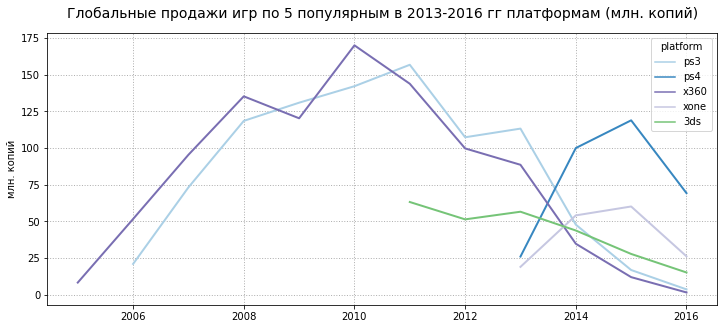

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (12, 5))

count = 0
for i in platforms_top5['company'].unique():

    sns.lineplot(x='year_of_release',
                 y='total_sales',
                 data=df_top5_grouped.query('company == @i'),
                 hue='platform',
                 legend='brief',
                 palette=palettes[count],
                 linewidth=2
                )
    count += 1
    
plt.title('Глобальные продажи игр по 5 популярным в 2013-2016 гг платформам (млн. копий)', fontsize=14, pad=15)
plt.xlabel('')
plt.ylabel('млн. копий')
plt.grid(linestyle=':', linewidth=1)
plt.show()

#### 3.3.1 Вывод

По сформированным данным видно, что из топ-5: 
- 2 платформы PlayStation от Sony (PS3, PS4), 
- 2 платформы от Microsoft (X360, XOne),
- 1 платформа от Nintendo (3DS).

По графику видно следующее:
- Платформы PS3 и X360 синхронно завершили свое существование – подошел к концу 10-ти летний срок, выпуск и продажа игр для этих платформ приблизились к нулевой отметке. В 2017 г. не стоит ожидать продаж по ним, платформы PS4 и XOne соответственно полностью их заменили.  


- Релизы PS4 и XOne состоялись в 2013 г. и если исходить из того, что средний срок жизни платформы 10 лет и пик продаж приходится на 4-ый – 5-ый год, то эти платформы должны были показывать стабильный рост, но они лишь два года росли, а потом показали падение, что говорит о каких-то системных изменениях на рынке компьютерных игр, и вполне вероятно, что в 2017 г. падение продолжится. Или как 2-ой вариант: мы имеем не полные данные за 2016 г., и на самом деле в 2017 г. стоит ждать дальнейшего роста продаж игр на платформах PS4 и XOne.


- Выход платформы XOne от MS оказался менее успешным, чем у конкурента Sony с платформой PS4.   


- Платформа 3DS от Nintendo показала довольно высокий уровень продаж в год выпуска (2011 г.), он же стал максимальным за рассматриваемый период, все последующие годы продажи находились в падени. И в целом 3DS от Nintendo заметно отстает от своих конкурентов.

### 3.4 Отзывы и продажи

Проанализируем влияние отзывов покупателей и критиков на объемы продаж игр по платформам из топ-5. Для этого построим диаграммы рассеивания и посчитаем корреляцию между отзывами и продажами.

In [32]:
scores = ['critic_score', 'user_score']
xlabels = ['оценка критиков', 'оценка пользователей']
scatter_colors=['#2768A7', '#1F8444']

In [33]:
def scatter(dataset, platform): # функция 2-х аргументов – датасет и анализируемая платформа
    fig, axes = plt.subplots(nrows=1, ncols=len(scores), figsize = (12, 3), sharey=True, )
    plt.suptitle('Диаграммы корреляции для платформы ' + platform, size=14, y=1)
    count = 0
    for i in range(len(scores)):
        ax = sns.scatterplot(data=dataset[(dataset['platform'] == platform) & (dataset[scores[count]] != -1)],
                             x=scores[count],
                             y='total_sales',
                             ax=axes[count],
                             color=scatter_colors[count]
                            ) 
        ax.set_ylabel('глобальные продажи, млн. копий')
        ax.set_xlabel(xlabels[count])
        count += 1
    plt.show()

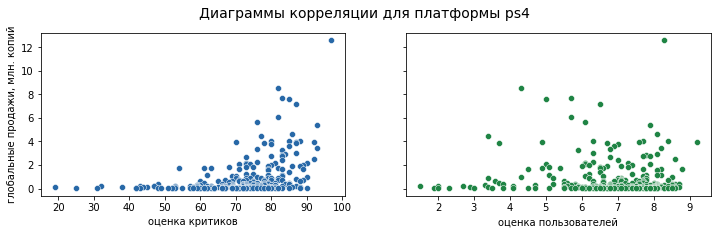

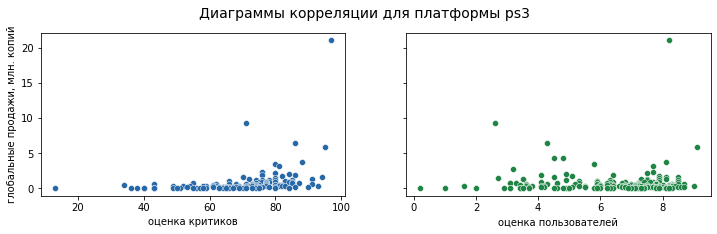

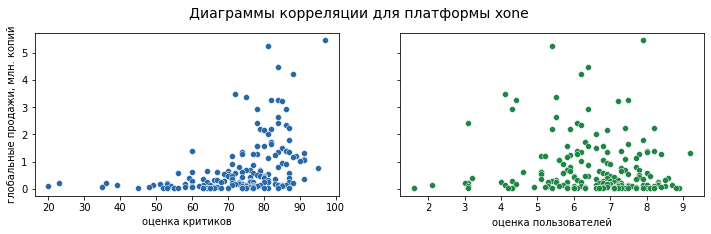

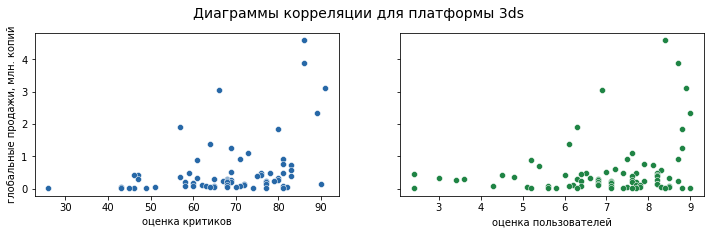

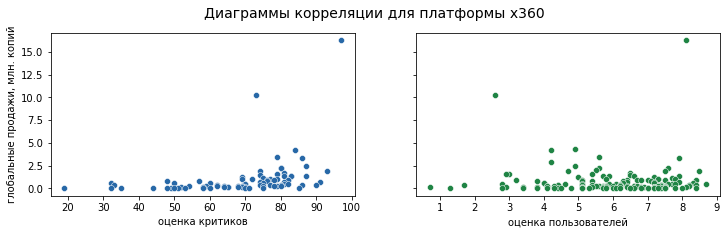

In [34]:
for platform in platforms_top5['platform'].unique():
    scatter(adf, platform)

In [35]:
result = []
for platform in platforms_top5['platform'].unique():
#зависимость продаж от отзывов пользователей    
    user_score_corr = round(adf.query('user_score != -1 & platform == @platform')['total_sales']
                            .corr(adf.query('user_score != -1 & platform == @platform')['user_score'])
                            , ndigits=2
                            )
#зависимость продаж от отзывов критиков    
    critic_score_corr = round(adf.query('critic_score != -1 & platform == @platform')['total_sales']
                              .corr(adf.query('critic_score != -1 & platform == @platform')['critic_score'])
                              , ndigits=2
                            )
    
    result.append({'platform': platform,
                   'user_score_corr': user_score_corr,
                   'critic_score_corr': critic_score_corr,
                  })

corr = pd.DataFrame(result, columns=['platform', 'user_score_corr', 'critic_score_corr'])
corr

,platform,user_score_corr,critic_score_corr
0,ps4,-0.03,0.41
1,ps3,0.00,0.33
2,xone,-0.07,0.42
3,3ds,0.24,0.36
4,x360,-0.01,0.35


<div class="alert alert-danger"
Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

#### 3.4.1 Вывод

Графики и расчеты показали следующее:

- *Пользовательские отзывы* никак не влияют на продажи игр. Платформа 3DS от Nintendo единственная проявила слабую положительную зависимость между двумя этими показателями.


- *Отзывы критиков* более выражено проявляют влияние на объемы продаж игр, но все равно зависимость можно охарактеризовать лишь как среднюю.

### 3.5 Игровые жанры

Посмотрите на продажи игр по жанрам за анализируемый период 2013-2016 гг.

In [36]:
genres = (adf.groupby('genre')
             .agg({'total_sales': 'sum'})
             .sort_values(by='total_sales', ascending = False)
         )
    
genres['total_sales_ratio, %'] = round(genres['total_sales'] / genres['total_sales'].sum() * 100, ndigits=2)
genres

,total_sales,"total_sales_ratio, %"
genre,,
action,321.87,29.51
shooter,232.98,21.36
sports,150.65,13.81
role-playing,145.89,13.38
misc,62.82,5.76
platform,42.63,3.91
racing,39.89,3.66
fighting,35.31,3.24
adventure,23.64,2.17


In [37]:
genres_top = genres.head(5).copy()
genres_top.loc['others', 'total_sales'] = genres['total_sales'].sum() - genres_top['total_sales'].sum()
genres_top = genres_top.reset_index()

In [38]:
colors = sns.color_palette('Blues_r', 8)[1:]

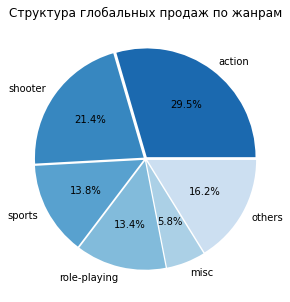

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (8, 5))
plt.pie(genres_top['total_sales'],
        labels=genres_top['genre'],
        autopct="%0.1f%%",
        startangle = 0,
        explode=[0.02]*(len(genres_top)),
        colors=colors
        )
plt.title('Структура глобальных продаж по жанрам', size=12)
plt.show()

#### 3.5.1 Вывод

В анализируемом периоде (2013-2016 гг) самыми продаваемыми жанрами стали `action` и `shooter`.

Далее следуют `sport` и `role-playing`.

Замыкают топ-5 самых популярных жанров игры в жанре `misc`, но их продажи существенно ниже предыдущих 2-х жанров.
Поэтому начиная с жанра misc и все последующие можно отнести к жанрам низкой популярности.

### 3.6 Вывод по разделу

В ходе исследовательского анализа данных были получены следующие результаты: 

>До 2008 г. рынок видеоигр активно развивался, но начиная с 2009 г. его начал теснить рынок мобильных игр. Стремительное падение продолжалось до 2013 г. С 2013 г. наблюдается определенная стабилизация, когда рынок компьютерных игр держится в интервале 500-600 выпущенных игр в год, но имеет тенденцию к снижению.

>С 2013 г. на рынке лидируют платформы от компании Sony (Play Station), с ними активно конкурируют платформы от Microsoft (Xbox), платформы компании Nintendo на 3-ем месте, но с существенным отставанием.

>Средний срок жизни игровой платформы около 10 лет, пик продаж приходится на 4-5 год, на 6 год разработчик обычно запускает на рынок следующий релиз платформы, который за 4 года полностью сменяет предыдущий.

>Отзывы покупателей практически не влияют на продажи. К отзывам критиков прислушиваются больше, но все-равно их влияние на продажи проявляется слабо.

>Среди игровых жанров лидируют: action, shooter, sports, role-playing. Остальные жанры пользуются довольно низкой популярностью среди игроков.

<a id='regions'></a>
## 4 Региональные особенности продаж игр

### 4.1 Структура глобальных продаж по регионам

Посмотрим на структуру глобальных продаж по регионам за анализируемый период 2012-2016 гг.

In [40]:
reg_list = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']

In [41]:
result = []
for reg in reg_list:
    sales = adf[reg].sum()
    ratio = round(adf[reg].sum() / adf['total_sales'].sum() * 100, ndigits=0)
    result.append({'regions': reg,
                   'total_sales': sales,
                   'total_sales_%': ratio
                  })

reg_total_sales = pd.DataFrame(result, columns=['regions', 'total_sales', 'total_sales_%'])

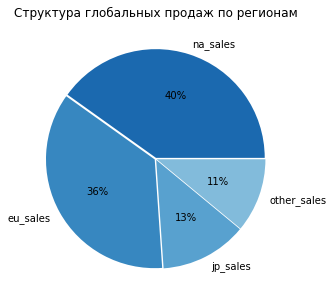

,regions,total_sales,total_sales_%
0,na_sales,437.71,40.0
1,eu_sales,392.23,36.0
2,jp_sales,140.78,13.0
3,other_sales,119.97,11.0


In [42]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (8, 5))

plt.pie(reg_total_sales['total_sales'],
        labels=reg_total_sales['regions'],
        autopct="%0.0f%%",
        startangle = 0,
        explode=[0.01]*(len(reg_total_sales)),
        colors=colors
        )             
plt.title('Структура глобальных продаж по регионам', size=12)
plt.show()
display(reg_total_sales)

#### 4.1.1 Вывод

В структуре глобальных продаж лидирует *Северная Америка*, на нее приходится 40% от всего объема проданных копий за 2013-2016 гг.

Далее следует *Европа* – 36% от глобальных продаж.

*Япония* – 13% и *остальные регионы* – 11%.

### 4.2 Структура региональных продаж по платформам

Определим для каждого региона самые популярные платформы (топ-5). Платформы, не вошедшие в топ-5, объединим в одну группу others. Посмотрим на структуру получившихся данных.

Для этого напишем пользовательскую функци.

In [43]:
# функция 3-х аргументов (#рассматриваемый датасет,
                          #анализируемый разрез данных,
                          #кол-во топовых позиций) для построения графиков структуры
        
def reg_structure(dataset, parameter, ntops):
# определяет для каждого региона указанное кол-во топовых позиций по выбранному параметру. 
# позиции, не вошедшие в топ, объединяет в группу others по каждому из регионов.
# для каждой позиции, в т.ч. others, считает суммарные продажи за 2013-2016 гг.
# строит pie-чарты на основе полученных данных. 

    cols = len(reg_list) # подсчет кол-ва регионов
    fig, axes = plt.subplots(nrows=1, ncols=cols, figsize = (20, 5)) # область построения графиков
    plt.suptitle('Структура региональных продаж', fontsize=20)
    
    count = 0    
    for i in range(cols):
        reg_grouped = (dataset.groupby(parameter)
                              .agg(sales = (reg_list[count], 'sum'))
                              .sort_values(by='sales', ascending=False) # суммарные продажи по каждой позиции по региону
                  )
        reg_top = reg_grouped.head(ntops).copy() # топ позиций с наибольшими продажами по региону
        reg_top.loc['others', 'sales'] = reg_grouped['sales'].sum() - reg_grouped['sales'].head(ntops).sum()
        # определение оставшихся позиций в категорию others и суммарных продаж по ним по региону
        reg_top['region'] = reg_list[count] # добавление столбца с именем региона
        reg_top = reg_top.reset_index()
        
        axes[i].pie(reg_top[reg_top['sales'] != 0]['sales'],
                    labels=reg_top[reg_top['sales'] != 0][parameter],
                    autopct="%0.0f%%",
                    startangle=0,
                    explode=[0.01]*len(reg_top[reg_top['sales'] != 0]),
                    colors=colors
                    )   
        axes[i].set_title(reg_list[count], size=12)
        count += 1 

    plt.show()

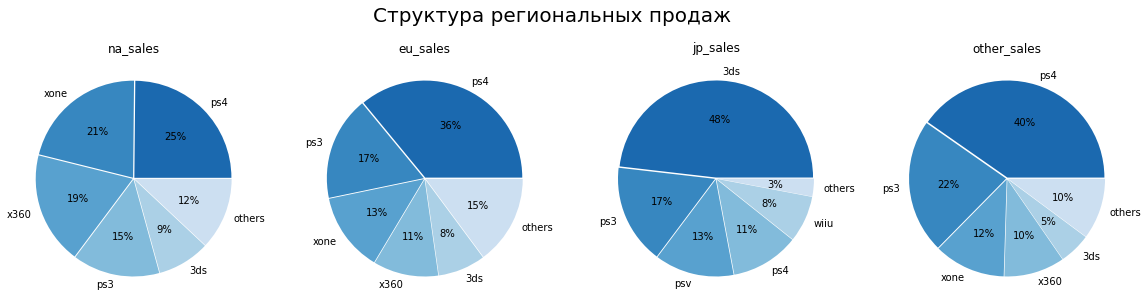

In [44]:
reg_structure(adf, 'platform', 5)

Воспользуемся написанной функцией и посмотрим для каждого региона структуру продаж по компаниям-разработчикам платформ.

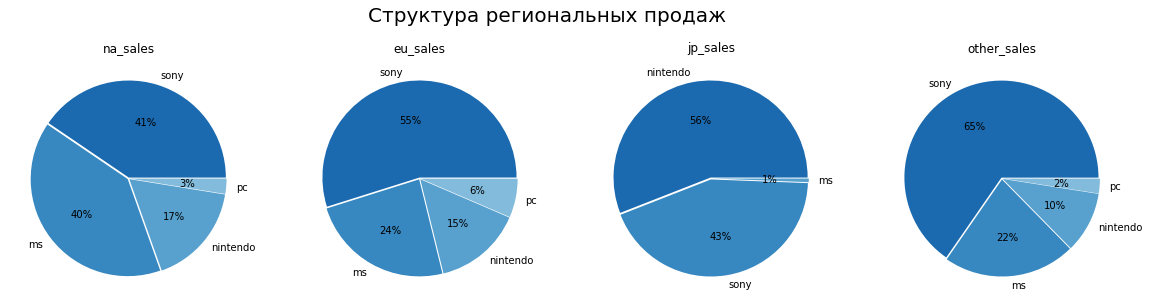

In [45]:
reg_structure(adf, 'company', df['company'].nunique())

#### 4.2.1 Вывод

Графики, построенные по данным за анализируемый период 2013-2016 гг., показали, что каждый регион имеет свои особенности в предпочтениях по платформам:

*СЕВЕРНАЯ АМЕРИКА*

- Sony (PS4, PS3) и Microsoft (XOne, X360) вместе сформировали 81% регионального рынка продаж, который разделили практически поровну: 41% пришлось на Sony и 40% на MS. На примере новейших платформ высокая конкуренция между Sony и MS также хорошо видна: на долю PS4(Sony) и XOne(MS) пришлось 25% и 21% от общего объема продаж соответственно.

- Nintendo только 17% рынка.

- Доля игр для персональных компьютеров (PC) всего 3%.


*ЕВРОПА*

- Совместная доля Sony и Microsoft также почти 80% регионального рынка, но бесспорными лидерами являются игровые платформы компании Sony (PS4, PS3) – 55% рынка, а Microsoft (XOne, X360) – только 24%. Продажи игр для новейших игровых платформ PS4(Sony) и XOne(MS) также демонстрируют лидерство Sony: 36% – PS4, 13% – XOne.
- Nintendo только 15% рынка.
- Доля игр для персональных компьютеров (PC) выше, чем в Северной Америке, и составила 6%.

*ЯПОНИЯ*

- Игры для платформ Microsoft практически отсутствуют на рынке, их доля всего 1%.
- Рынок делят игры для Nintendo (3DS, WiiU) и Sony (PS4, PSV, PS3), при этом Nintendo является лидером – 56% рынка, в то время как Sony – 43%.
- В Японии прослеживается большая популярность портативных консолей: игры для 3DS от Nintendo и PSV от Sony вместе сформировали 61% продаж.
- Игры для персональных компьютеров совсем не представлены на японском рынке.

*ОСТАЛЬНЫЕ РЕГИОНЫ*

- Структура рынка напоминает европейскую: совместная доля Sony и Microsoft – 87% рынка. С большим перевесом лидирует Sony – 65% против 22% у Microsoft. Лидерство Sony сохраняется и на продажах игр для новейших платформ: PS4 – 40%, XOne – 12%.
- Nintendo только 10% рынка.
- Доля игр для персональных компьютеров (PC) такая же низкая, как в Северной Америке – только 2%.

### 4.3 Структура региональных продаж по жанрам

Воспользуемся написанной функцией `reg_structure` и посмотрим для каждого региона структуру продаж по игровым жанрам. 

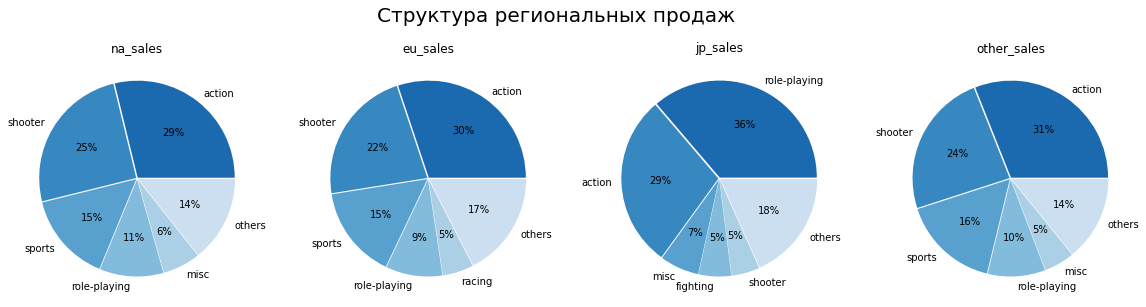

In [46]:
reg_structure(adf, 'genre', 5)

Также посмотрим в динамике, как менялись жанровые предпочтения пользователей на примере жанров, которые входят в топ-4.

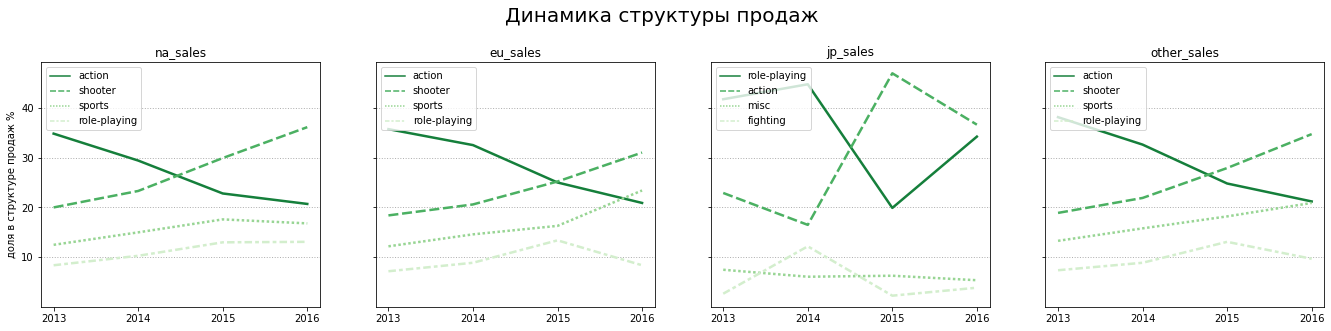

In [47]:
cols = len(reg_list)
fig, axes = plt.subplots(nrows=1, ncols=cols, figsize = (23, 4.5), sharey=True)
plt.suptitle('Динамика структуры продаж', fontsize=20, y=1.05)
    
count = 0
for i in range(cols): 
    top_list = (adf
                .groupby('genre')
                .agg(sales = (reg_list[count], 'sum'))
                .sort_values(by='sales', ascending=False)
                .head(4)
                .reset_index()
                )['genre']
    result = []
    for year in years_list:
        df_st = (adf
                    .query('year_of_release == @year')
                    .groupby('genre')
                    .agg(sales = (reg_list[count], 'sum'))
                    .sort_values(by='sales', ascending=False)
                )
        df_st_top = df_st[df_st.index.isin(top_list)].copy()
        df_st_top['share%'] = round(df_st_top['sales'] / df_st['sales'].sum() * 100, ndigits=1)
        df_st_top['region'] = reg_list[count]
        df_st_top['year'] = year
        result.append(df_st_top)
            
    dfs = pd.concat(result).reset_index()
            
    ax = sns.lineplot(x='year',
                          y='share%',
                          data=dfs[dfs['region'] == reg_list[count]],
                          hue='genre',
                          style='genre',
                          legend='brief',
                          palette='Greens_r',
                          linewidth=2.5,
                          ax=axes[count],
                          ci=None
                         )
    ax.legend(loc='upper left')
    ax.set_xlabel('')
    ax.set_ylabel('доля в структуре продаж %')
    ax.set_xticks(dfs['year'].unique())  
    ax.set_title(reg_list[count], size=12)
    ax.grid(linestyle=':', linewidth=1, axis='y')
    count += 1 
plt.show()

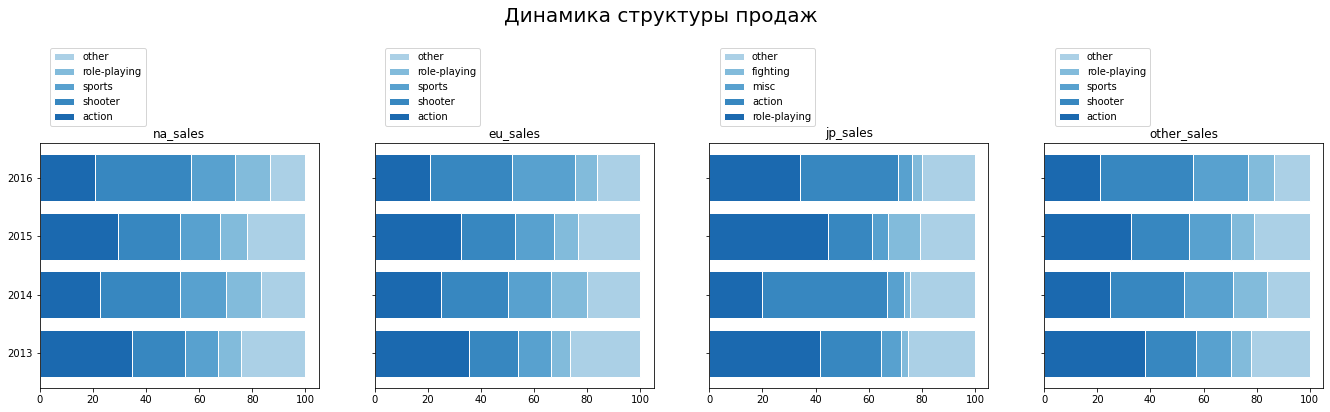

In [48]:
cols = len(reg_list) # подсчет кол-ва регионов
fig, axes = plt.subplots(nrows=1, ncols=cols, figsize = (23, 4.5), sharey=True)
plt.suptitle('Динамика структуры продаж', fontsize=20, y=1.3)
    
count = 0
for i in range(cols): 
    top_list = (adf
                .groupby('genre')
                .agg(sales = (reg_list[count], 'sum'))
                .sort_values(by='sales', ascending=False)
                .head(4)
                .reset_index()
                )['genre'].tolist() # перечень топовых позиций с наибольшими продажами по региону  
    genre_order = CategoricalDtype(top_list, ordered=True)
    df_st_cum = adf.groupby(['year_of_release', 'genre']).agg(sales = (reg_list[count], 'sum')).reset_index()
    df_top_cum = df_st_cum [df_st_cum ['genre'].isin(top_list)].copy()
    df_top_cum['genre'] = df_top_cum['genre'].astype(genre_order)
    df_top_cum = df_top_cum.sort_values(by=(['year_of_release', 'genre']))
    df_top_cum['cum'] = pd.concat(df_top_cum[df_top_cum['year_of_release'] == y]['sales'].cumsum() for y in years_list)
    df_top_cum['share'] = pd.concat(df_top_cum[df_top_cum['year_of_release'] == y]['cum'] / df_st_cum[df_st_cum['year_of_release'] == y]['sales'].sum() * 100 for y in years_list)

    x=years_list
    axes[i].barh(x, 100, color=colors[4], edgecolor='white')
    axes[i].barh(x, df_top_cum[df_top_cum['genre'] == top_list[3]]['share'], color=colors[3], edgecolor='white')
    axes[i].barh(x, df_top_cum[df_top_cum['genre'] == top_list[2]]['share'], color=colors[2], edgecolor='white')
    axes[i].barh(x, df_top_cum[df_top_cum['genre'] == top_list[1]]['share'], color=colors[1], edgecolor='white')
    axes[i].barh(x, df_top_cum[df_top_cum['genre'] == top_list[0]]['share'], color=colors[0], edgecolor='white')
    
    axes[i].set_yticks(x)
    top_list.append('other')
    labels=list(reversed(top_list))
    axes[i].legend(labels, bbox_to_anchor=(0.02, 1.05))
    axes[i].set_title(reg_list[count], size=12)
    count += 1
plt.show()  

#### 4.3.1 Вывод

Графики, построенные по данным за анализируемый период 2013-2016 гг., показали, что регионы Северная Америка, Европа и группа прочих регионов идентичны в жанровых предпочтениях:   

*1-е место* – action,   
*2-е место* – shooter,   
*3-е место* – sports,   
*4-е место* – role-playing.   

На указанные 4 жанра приходится 80%(+/-) рынка. 

Если говорить о динамики предпочтений за 4 анализируемых года, то по графикам видно следующее:

*СЕВЕРНАЯ АМЕРИКА*:

- жанр `shooter` поднялся со 2-го на 1-е место, сместив `action`; 
- на 3-ем месте жанр `sports`, но если `action` сохранит тенденцию к падению, то в ближайшем будущем может оказаться на 3-ем месте, уступив жанру `sports`;
- на 4-ом месте `role-playing`, который движется параллельно со `sports`;
- за 4 года суммарная доля первых 4х лидеров увеличилась практически до 90%, что говорит о сокращении интереса пользователей к другим видам жанров. 


*ЕВРОПА*

- жанр `action` упал с 1-го на 3-е место, в итоге жанр `shooter` вышел на 1-е место, а `sports` – на 2-е.
- `role-playing` – на 4-ом месте;
- за 4 года суммарная доля первых 4х лидеров также увеличилась, т.е. интерес пользователей к другим видам жанров снижается.

*ЯПОНИЯ*

- жанр `action` поднялся со 2-го на 1-е место, сместив `role-playing`;
- при этом график показывает, что жанры `action` и `role-playing` в ближайшее время снова могут поменяться местами;
- доля первых 2х лидеров около 70%, т.е. можно сказать, что остальные виды жанров очень мало интересуют японских игроков.

*ОСТАЛЬНЫЕ РЕГИОНЫ* имеют схожую с Северной Америкой и Европой картину.

- жанр `action` показал падение, а `shooter` и `sports` – наоборот рост, в итоге `shooter` на 1-ом месте, а `action` и `shooter` разделили 2-е место;
- `role-playing` – на 4-ом месте;
- также за 4 года увеличилась суммарная доля первых 4х лидеров.

### ESRB рейтинг

Воспользуемся написанной функцией `reg_structure` и посмотрим для каждого региона структуру предпочтений в разрезе ESRB рейтинга.

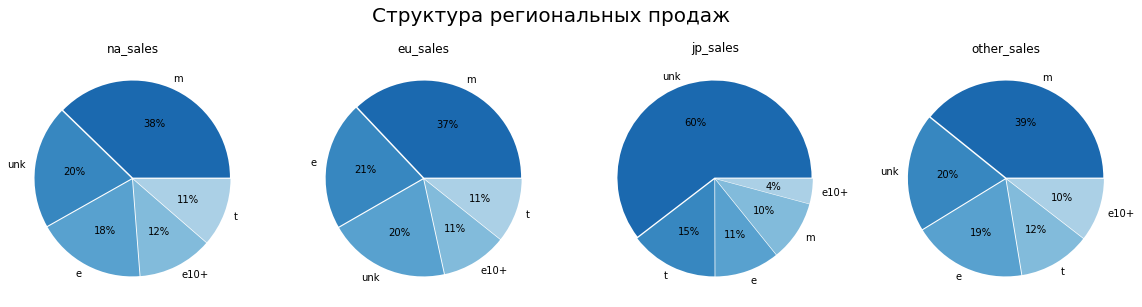

In [49]:
reg_structure(adf, 'rating', df['rating'].nunique())

Доля игр, для которых не указан рейтинг по ESRB (отмеченные маркером `unk`), очень высокая: 20% в NA, EU и others, и 60% в JP. Поэтому говорить о зависимости продаж от возрастного рейтинга игр сложно. 

Посмотрим на топ-5 игр с неизвестным рейтингом по каждому региону.

In [50]:
result = []
for reg in reg_list:
    unk = (adf.query('rating == "unk"')
              .groupby('name')
              .agg(sales = (reg, 'sum'))
              .sort_values(by='sales', ascending=False)
              .head(5)
          )
    unk['region'] = reg
    result.append(unk)

df_unk = pd.concat(result).reset_index().groupby(['region', 'name']).agg({'sales': 'sum'})
df_unk

sales
region      name                                            
eu_sales    call of duty: black ops 3                   9.49
            minecraft                                   8.75
            pokemon omega ruby/pokemon alpha sapphire   3.49
            pokemon x/pokemon y                         4.19
            star wars battlefront (2015)                5.15
jp_sales    monster hunter 4                            3.44
            pokemon omega ruby/pokemon alpha sapphire   3.10
            pokemon x/pokemon y                         4.35
            super smash bros. for wii u and 3ds         3.24
            yokai watch 2 ganso/honke                   3.18
na_sales    call of duty: black ops 3                  12.25
            minecraft                                  11.28
            pokemon x/pokemon y                         5.28
            star wars battlefront (2015)                5.16
            super smash bros. for wii u and 3ds         5.87
other_sales call of duty: black ops 3                   3.49
            minecraft                                   2.89
            star wars battlefront (2015)                1.64
            super smash bros. for wii u and 3ds         0.86
            tomb raider (2013)                          0.92

Для полученного перечня игр найдем в интернет-источниках данные о рейтинге и заменим `unk` на соответствующий.

In [51]:
df_unk.reset_index()['name'].unique()

array(['call of duty: black ops 3', 'minecraft',
       'pokemon omega ruby/pokemon alpha sapphire', 'pokemon x/pokemon y',
       'star wars battlefront (2015)', 'monster hunter 4',
       'super smash bros. for wii u and 3ds', 'yokai watch 2 ganso/honke',
       'tomb raider (2013)'], dtype=object)

In [52]:
esrb = {'call of duty: black ops 3': 'm',
        'minecraft': 'e10+',
        'pokemon omega ruby/pokemon alpha sapphire': 'e',
        'pokemon x/pokemon y':'e',
        'star wars battlefront (2015)': 't',
        'monster hunter 4': 't',
        'super smash bros. for wii u and 3ds': 'e10+',             
        'yokai watch 2 ganso/honke': 'e10+',
        'tomb raider (2013)': 'm'
        }

In [53]:
for key in esrb:
    df.loc[(df['name'] == key), ['rating']] = df.loc[(df['name'] == key), ['rating']].replace('unk', esrb[key])

Снова посмотрим на региональные предпочтения игроков в разрезе ESRB рейтинга.

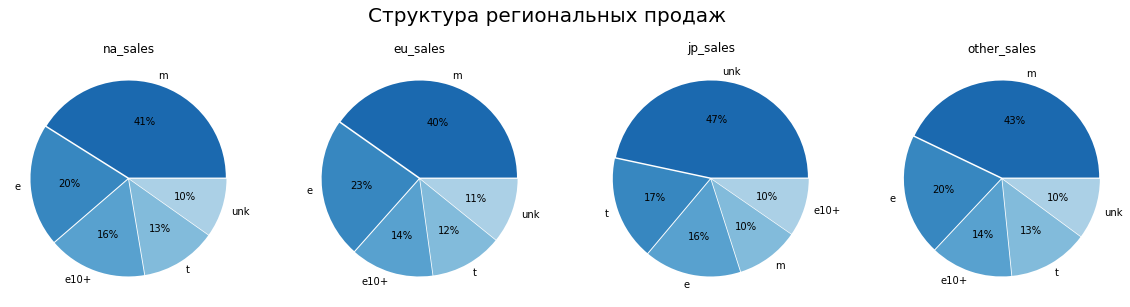

In [54]:
reg_structure(df[df['year_of_release'].isin(years_list)], 'rating', df['rating'].nunique())

Посмотрим, игры каких компаний-разработчиков не имеют рейтинга, т.е. отмечены как `unk`.

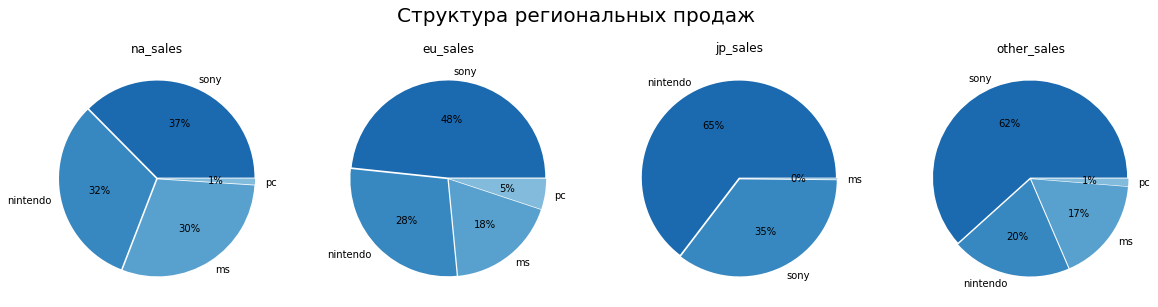

In [55]:
reg_structure(df[(df['year_of_release'].isin(years_list)) & (adf['rating'] == 'unk')], 'company', df['company'].nunique())

#### 4.4.1 Вывод

На данном этапе неизвестные значения рейтинга для топ-5 популярных игр по каждому из регионов были заменены на реальные по данным из интернет-источников. После этого стало возможным говорить более определенно о региональных предпочтениях игроков.

*Северная Америка, Европа и группа остальных стран* демонстрируют идентичные предпочтения: 
- 1-е место – игры для взрослых (от 17 лет) – M (Mature),
- 2-е место – игры для всех – Е (Everyone),
- 3-е место – игры для всех старше 10 лет – Е10+ (Everyone 10 and older),
- 4-е место – игры для подростков от 13 лет – Т (Teen).

В *Японии* большая доля игр так и сталась без рейтинга ESRB. Судя по данным, эти игры для платформ от Nintendo, к которым применяется своя региональная система рейтингов.

### 4.5 Вывод по разделу

Анализируя региональные особенности рынка компьютерных игра за период 2013-2016 гг., можно сказать следующее:

*ОБЩИЕ ПРОДАЖИ*

>- Основной объем продаж компьютерных игр – 76% – приходится на североамериканский и европейский рынки. При этом Северная Америка не на много превосходит Европу: NA – 40%, EU – 36% от общего объема продаж. 
>- Оставшуюся часть делят между собой Япония и группа прочих регионов также примерно в одинаковых долях: JP – 13%, прочие – 11%.

*ЖАНРОВЫЕ ПРЕДПОЧТЕНИЯ*

>- Северная Америка, Европа и группа прочих регионов имеют идентичные списки жанров-лидеров: action, shooter, sports, role-playing. На долю этих 4х жанров приходится примерно 80% региональных рынков продаж.
>- Японский рынок имеет свои особенности: около 70% рынка делят между собой 2-а основных жанра: action и role-playing, периодически меняясь местами по популярности.

*ПРЕДПОЧТЕНИЯ ПО ПЛАТФОРМАМ*

>- В Северной Америке и Европе на долю платформ от Sony и Microsoft приходится более 80% рынка.
>- При этом в Северной Америке предпочтения игроков практически поровну разделились между Sony и MS, в то время как в Европе игроки вдвое чаще покупают игры для платформ Sony, чем MS.
>- Японский рынок и в этом разрезе также сильно отличается: 56% рынка приходится на Nintendo (в то время, как в Северной Америке и Европе доля Nintendo 17% и 15% соответственно), оставшаяся часть рынка – Sony, платформы MS практическ отсуствуют.
>- Группа прочих регионов напоминает европейский рынок: совместная доля Sony и Microsoft – 87%. С большим перевесом лидирует Sony – 65% против 22% у Microsoft. Nintendo только 10% рынка.

*ПРЕДПОЧТЕНИЯ ПО РЕЙТИНГУ*

>- Североамериканский, европейский и рынок прочих регионов идентичны в своих предпочтениях: игры категории М (17+) пользуются наибольшей популярностью, затем идут игры категории Е (для всех), далее Е10+ (для всех старше 10 лет) и Т (для подростков от 13 лет).
>- О японском рынке сложно говорить в разрезе данной системы рейтингов, поскольку большую часть – 65% – составляют игры, не имеющие рейтинга ESRB. 

<a id='hypotheses'></a>
## 5 Проверка гипотез

### Сравнение пользовательских рейтингов платформ XOne и PC

**Выдвинем гипотезу №1:** средние пользовательские оценки платформ XOne и PC одинаковые. 

*Нулевая гипотеза H₀* будет звучать аналогично.   
Исходя из H₀ *альтернативная гипотеза H₁* будет звучать как: средние пользовательские оценки платформы XOne и PC не равны.

Для проверки гипотез воспользуемся мнетодом scipy.stats.ttest_ind (array1, array2, equal_var).

Зададим пороговое значение на уровне 5%.

Проверять гипотезу будем на данных за актуальный период – 2013-2016 гг.

In [56]:
alpha = 0.05 # критический уровень статистической значимости

xone = adf.query('user_score != -1 & platform == "xone"')['user_score']
pc = adf.query('user_score != -1 & platform == "pc"')['user_score']

results_platforms = st.ttest_ind(xone, pc, equal_var=False)

print('p-значение:', '{0:.4f}'.format(results_platforms.pvalue))

if results_platforms.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 
    
# выводим среднюю оценку по платформам
print()  
print('Средняя пользовательская оценка XOne:', '{0:.1f}'.format(adf.query('user_score != -1 & platform == "xone"')['user_score'].mean()))
print('Средняя пользовательская оценка PC:', '{0:.1f}'.format(adf.query('user_score != -1 & platform == "pc"')['user_score'].mean()))

p-значение: 0.1476
Не получилось отвергнуть нулевую гипотезу

Средняя пользовательская оценка XOne: 6.5
Средняя пользовательская оценка PC: 6.3


#### 5.1.1 Вывод

Мы получили высокое значение p-value – 14.8%, т.е. отвергая нулевую гипотезу, мы с 14.8% вероятности можем ошибиться – это выше, чем заложенный уровень погрешности в 5%.

Не получается отвергнуть нулевую гипотезу и можно говорить о том, что статистически значимых различий в средней пользовательской оценке платформ XOne и PC нет.

### Сравнение пользовательских рейтингов жанров Action и Sports

**Выдвинем гипотезу №2:** средние пользовательские оценки жанров Action и Sports разные. 

*Нулевая гипотеза H₀* будет звучать как: средние пользовательские оценки жанров Action и Sports равны.    
Исходя из H₀ *альтернативная гипотеза H₁* будет звучать как: средние пользовательские оценки жанров Action и Sports не равны.

Для проверки гипотез воспользуемся мнетодом scipy.stats.ttest_ind (array1, array2, equal_var).

Зададим пороговое значение на уровне 5%.

Проверять гипотезу будем на данных за актуальный период – 2013-2016 гг.

In [57]:
alpha = 0.05 # критический уровень статистической значимости

action = adf.query('user_score != -1 & genre == "action"')['user_score']
sports = adf.query('user_score != -1 & genre == "sports"')['user_score']

results_genres = st.ttest_ind(action, sports, equal_var=False)

print('p-значение:', results_genres.pvalue)

if results_genres.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 
    
# выводим среднюю оценку по жанрам
print()  
print('Средняя пользовательская оценка Action:', '{0:.1f}'.format(adf.query('user_score != -1 & genre == "action"')['user_score'].mean()))
print('Средняя пользовательская оценка Sports:', '{0:.1f}'.format(adf.query('user_score != -1 & genre == "sports"')['user_score'].mean()))

p-значение: 1.4460039700704315e-20
Отвергаем нулевую гипотезу

Средняя пользовательская оценка Action: 6.8
Средняя пользовательская оценка Sports: 5.2


#### 5.2.1 Вывод

Мы получили значение p-value, стремящееся к нулю, т.е. вероятность ошибиться, отвергая нулевую гипотезу, ничтожна мала. Значит существует различие в средних пользовательских оценках жанров Action и Sports и оно статистически значимо: игроки выше оценивают игры жанра Action, чем жанра Sports.

<a id='conclusion'></a>
## 6 Общий вывод и рекомендации

На основе проведенного анализа  исторические данные о продажах игр, оценках пользователей и экспертов, жанрах и платформах за период 1980-2016 гг. можно сделать следующие **ВЫВОДЫ**:

> На текущий момент на рынок компьютерных игр оказывает сильное влияние рынок мобильных и онлайн игр. Стремительное падение, которое продолжалось с 2009 г по 2013 г., остановилось, и рынок несколько стабилизировался, но имеет тенденцию к снижению.

> Лидерами рынка за период 2013-2016 гг являются Sony и Microsoft. Nintendo на 3-ем месте, но с существенным отставанием. Единственный регион, где Nintendo лидирует и занимает более 50% рынка – это Япония, но продажи в Японии составляют лишь 13% от общего объема, поэтому в глобальном плане Nintendo сильно отстает от своих конкурентов.

> На конец 2016 г. на глобальном рынке лидирующими платформами являются PS4 (Sony), XOne (MS) и 3DS (Nintendo), но все эти платформы имеют тренд на снижение, несмотря на их недавний релиз. 3DS, запустившись очень успешно в 2011 г., сразу после запуска показала падение продаж. PS4 и XOne после релиза 2013 г. имели возрастающий тренд, но в 2015 г. синхронно показали падение. Возможно, вмешался глобальный фактор, связанный с рынком мобильных и онлайн игр. Или жи мы имеем не полные данные за 2016 г. Поэтому в первом случае в 2017 г. стоит ожидать продолжения падения, а во втором случае – что платформы PS4 и XOne все же будут показывать рост еще на протяжении 2-3 лет.

> Отзывы покупателей, не смотря на кажущуюся их значимость, практически не влияют на продажи. К отзывам критиков прислушиваются больше, но все-таки их влияние на продажи проявляется слабо.

> Среди игровых жанров лидируют: action, shooter, sports, role-playing. Остальные жанры пользуются довольно низкой популярностью среди игроков.
При этом на североамериканском, европейском и рынке прочих регионов жанр action за последние 4 года сдал свои позиции, опустившись на 2-е место в Америке и прочих регонах и на 3-е место в Европе, и пропустив вперед жанры shooter и sports. В Японии action в 2015 г. наоборот взлетел в рейтингах, сильно обогнав своего единственного конкурента – role-playing, но в 2016 г. эти два жанра снова показали тенденцию к тому, чтобы поменяться местами.

> Самыми популярными играми на рынках, исключая Японию, являются игры с рейтингом М (от 17 лет) – ок 40% рынка, примерно в 2 раза менее популярными являются игры с рейтингом E (для всех). Игры рейтингов E10+, T и прочее примерно в равных долях делят оставшиеся 40% рынка.
Японский рынок и здесь выделяется, тем, что почти половина игр, выпускаемая в этом регионе, не имеет рейтинга по ESRB – это игры для платформ от Nintendo.


Для планирования продаж на 2017 г. можно предложить следующий список **РЕКОМЕНДАЦИЙ**:

>- Во всех регионах, исключая Японию, основную долю продаж можно ожидать от игр для платформ PS4 и XOne, поскольку предыдущие версии этих платформ скорее всего ушли с поддержки со стороны разработчика, а новым еще рано появляться.
>- На японском рынке игры для 3DS от Nintendo и актуальных платформ от Play Station (PS4 и PSV) скорее всего возьмут на себя практически весь объем продаж в регионе.

>- В регионах, исключая Японию, необходимо делать упор на продажи игр жанров shooter, sports, action, role-playing.
>- На рынке Японии основной доход ожидаемо принесут игры жанра action и role-playing.

>- По ESRB рейтингам в регионах, исключая Японию, необходимо принимать во внимание, что 60% рынка приходится на игры с рейтингом М (17+) и Е (для всех).
>- Для Японского рынка нужно анализировать их собственную рейтинговую систему, поскольку почти половина игр, продающихся в этом регионе, не имеют рейтинга по ESRB.

>- Планируя продажи на 2017 г. не имеет смысла ориентироваться на пользовательские рейтинги и рейтинги критиков, их влияние на продажи очень слабо проявляется.

In [58]:
# Предобработанный датасет преобразуем в строко-ориентированную таблицу и выгружаем для создания дашборда в Tableau
games_rot = df.drop('total_sales', axis=1).copy()

games_rot = games_rot.melt(id_vars=['name', 'platform', 'year_of_release',
                             'genre', 'critic_score', 'user_score',
                             'rating', 'company'], 
                           value_vars=['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
                           )

games_rot = games_rot.rename(columns={'variable': 'region', 'value': 'sales'})

games_rot.to_csv('games_rot.csv', index=False)